In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


#  **EDA**

In [2]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv",index_col=0)
df.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
x_df = df.drop("SalePrice",axis=1)
y_df = df["SalePrice"]

In [5]:
y_df.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
missing_xdf_values = x_df.isnull().sum()
filter_miss_xdf = missing_xdf_values.loc[missing_xdf_values != 0]
filter_miss_xdf

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
import plotly.express as px
fig = px.histogram(y_df, x="SalePrice")
fig.show()

The histogram shows us that the data is skewed to the right with a mean of 180,921, median of 163,000, meaning the data is not quite normally distributed. This is an important observation to make as using a linear regression model may not yield accurate results since the outliers have a large impact on the line of best fit calculated during training. Thus we can use the log function to convert this skwewed data into a normally distributed one. In general if the data is right-skewed, log-transforming will result in a normal distribution, and a square root transfomration will result in a normal distribution for left-skewed data.

In [8]:
import numpy as np
y_df = np.log(y_df)
fig = px.histogram(y_df, x="SalePrice")
fig.show()

Now we have a nice normal distribution for the SalePrice. This should help improve our accuracy when using a linear regression model.

Missing Values in %

In [9]:
print(filter_miss_xdf*100/1460)

LotFrontage     17.739726
Alley           93.767123
MasVnrType      59.726027
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64


In [10]:
waste_xdf_ = filter_miss_xdf.loc[filter_miss_xdf*100/1460 > 10]
waste_xdf = waste_xdf_.index.tolist()
print(waste_xdf)

['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [11]:
missing_ydf_values = y_df.isnull().sum()
print(missing_ydf_values)

0


# **Data Preprocessing**

In [12]:
x = x_df.drop(waste_xdf,axis=1)
y = y_df

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [14]:
string_columns = x_train.select_dtypes(include=['object']).columns.tolist()
numeric_columns = x_train.select_dtypes(include=['int','float']).columns.tolist()
print(string_columns)
print(numeric_columns)
print(len(string_columns)+len(numeric_columns))

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
72


In [15]:
ordinal = ['LotShape', 'LandContour', 'Utilities', 'LandSlope','HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond']
nominal = [column for column in string_columns if column not in ordinal]
print(nominal)

['MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 'PavedDrive', 'SaleType', 'SaleCondition']


In [16]:
print((len(nominal)+len(ordinal))==len(string_columns))
print((len(string_columns)+len(numeric_columns))==72)

True
True


In [17]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer

# Define which transformers to apply to which columns
numeric_transformer = Pipeline(steps=[
    ('numeric_imputer', SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])

string_ordinal_transformer = Pipeline(steps=[
    ('ordinal_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

string_nominal_transformer = Pipeline(steps=[
    ('nominal_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
# Create column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_columns),
    (string_ordinal_transformer, ordinal),
    (string_nominal_transformer, nominal)
)

In [19]:
# Create the full pipeline
pipeline = make_pipeline(preprocessor)
# Apply the pipeline to the DataFrame
x_train_transformed = pipeline.fit_transform(x_train)

In [20]:
nominal_index = preprocessor.transformers_[2][0]  # Adjust the index based on the position of the nominal transformer
nominal_transformer = preprocessor.named_transformers_[nominal_index].named_steps['onehot']
columns = (numeric_columns +ordinal +
    list(nominal_transformer.get_feature_names_out(nominal))
)

In [21]:
x_train_transformed = pd.DataFrame(x_train_transformed, columns=columns)
x_train_transformed.head(3)

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.868365,0.103212,2.131506,-0.513041,1.188032,1.078914,1.913593,-0.901062,-0.291823,2.757198,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.868365,-0.372881,-0.794852,-0.513041,-0.292501,-1.097548,-0.568178,-1.011427,-0.291823,0.745229,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.631142,0.258919,-0.794852,1.278384,-1.641431,1.030548,-0.568178,0.627953,-0.291823,-0.926076,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
x_train_transformed.shape

(1168, 193)

# Modelling 

## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
linr=LinearRegression()
linr.fit(x_train_transformed,y_train)

LinearRegression()

In [24]:
linr.score(x_train_transformed,y_train)


0.9453726980827192

In [25]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
linr.score(x_test_transformed,y_test)

-1.0265241110767304e+17

## Ridge

In [26]:
from sklearn.linear_model import Ridge
ri=Ridge()
# Fit and transform on the training data
ri.fit(x_train_transformed,y_train)

Ridge()

In [27]:
ri.score(x_train_transformed,y_train)

0.9411529108297162

In [28]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
ri.score(x_test_transformed,y_test)

0.7452471428529599

## KNN Model

In [29]:
from sklearn.neighbors import KNeighborsRegressor
kn=KNeighborsRegressor()
kn.fit(x_train_transformed,y_train)

KNeighborsRegressor()

In [30]:
kn.score(x_train_transformed,y_train)

0.8700656348491226

In [31]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
kn.score(x_test_transformed,y_test)

0.770405943889885

## SVR Model

In [32]:
from sklearn.svm import SVR
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(x_train_transformed,y_train)

SVR(epsilon=0.2)

In [33]:
svr.score(x_train_transformed,y_train)

0.9174101760855634

In [34]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
svr.score(x_test_transformed,y_test)

0.8562814542006859

## DECISION TREE REGRESSOR

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)

tree.fit(x_train_transformed, y_train)

DecisionTreeRegressor(random_state=42)

In [36]:
tree.score(x_train_transformed, y_train)

1.0

In [37]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
tree.score(x_test_transformed,y_test)

0.7121026476392684

## Bagging

In [38]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Create a base regressor (you can use any regression model)
base_regressor = DecisionTreeRegressor()

# Create the BaggingRegressor
bagging_regressor = BaggingRegressor(base_regressor, random_state=42)

# Fit the model to the training data
bagging_regressor.fit(x_train_transformed, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)

In [39]:
bagging_regressor.score(x_train_transformed,y_train)

0.9709709019508094

In [40]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
bagging_regressor.score(x_test_transformed,y_test)

0.8621051992851276

## Boosting

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
boo = GradientBoostingRegressor()
boo.fit(x_train_transformed, y_train)

GradientBoostingRegressor()

In [42]:
boo.score(x_train_transformed, y_train)

0.9635812783148133

In [43]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
boo.score(x_test_transformed,y_test)

0.8928908715579231

## RANDOM FOREST REGRESSOR

In [44]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(x_train_transformed, y_train)

RandomForestRegressor()

In [45]:
regr.score(x_train_transformed, y_train)

0.9822402000275372

In [46]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
regr.score(x_test_transformed,y_test)

0.8693239308320239

## MLR Model

In [47]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter = 1000)
mlp.fit(x_train_transformed,y_train)

MLPRegressor(max_iter=1000)

In [48]:
mlp.score(x_train_transformed, y_train)

0.9364814645698413

In [49]:
mlp.score(x_test_transformed, y_test)

0.290563337736255

**The test scores of above models are**

linear reg:    -1.02

ridge:         0.74

KNN:           0.87

SVR:           0.85

desicion tree: 0.71

Bagging:       0.86

Boosting:     0.887

Random forest: 0.878

MLP:           0.43

**The best model without hypertuining is Boosting**

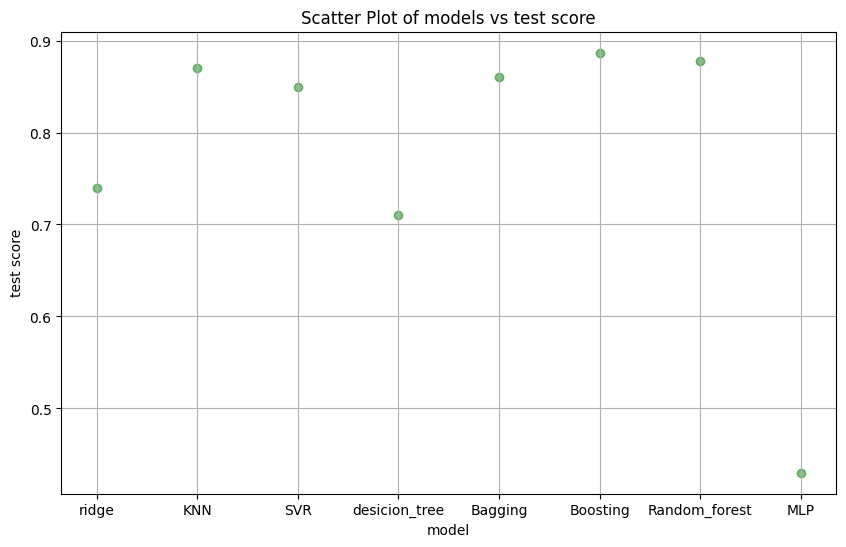

In [50]:
q1 = ['ridge', 'KNN', 'SVR', 'desicion_tree', 'Bagging', 'Boosting', 'Random_forest', 'MLP']
q2 = [ 0.74, 0.87, 0.85, 0.71, 0.86, 0.887, 0.878, 0.43]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(q1, q2, color='green', alpha=0.5)
plt.title('Scatter Plot of models vs test score')
plt.xlabel('model')
plt.ylabel('test score')
plt.grid(True)
plt.show()


# Hypertunning

In [51]:
import warnings
warnings.filterwarnings("ignore")

## DECISION TREE REGRESSOR

In [52]:
p_grid ={ 'max_depth': [10, 20, 30, 40],
    'min_samples_split': [5, 10,15, 20],
    'min_samples_leaf': [5, 10,15,20], }

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
ri=DecisionTreeRegressor()
gri_search_cv = GridSearchCV(ri,p_grid,cv=5,scoring='r2')
gri_search_cv.fit(x_train_transformed,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='r2')

In [54]:
best_parameters=gri_search_cv.best_params_
print(best_parameters)

{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [55]:
from sklearn.tree import DecisionTreeRegressor
rr=DecisionTreeRegressor(**best_parameters)

In [56]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rr, x_train_transformed, y_train, cv=5)
cv_scores

array([0.79204084, 0.72791966, 0.7906824 , 0.79805998, 0.74430998])

In [57]:
rr.fit(x_train_transformed,y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=20)

In [58]:
rr.score(x_train_transformed,y_train)

0.8975950502753058

In [59]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
rr.score(x_test_transformed,y_test)

0.7510510985495936

## Bagging 

In [60]:
param_grid = {
     'n_estimators': [50, 100, 150],
     'max_samples': [0.7, 0.8, 0.9],
     'max_features': [0.7, 0.8, 0.9]
 }

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor


# Create a base regressor (you can use any regression model)
base_regressor = DecisionTreeRegressor()

 # Create the BaggingRegressor
bagging_regressor = BaggingRegressor(base_regressor, n_estimators=10, random_state=42)

gri_search_cv5 = GridSearchCV(bagging_regressor,param_grid,cv=5,scoring='r2')

# Fit the model to the training data
gri_search_cv5.fit(x_train_transformed, y_train)


GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor(),
                                        random_state=42),
             param_grid={'max_features': [0.7, 0.8, 0.9],
                         'max_samples': [0.7, 0.8, 0.9],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

In [62]:
best_parameters_1=gri_search_cv5.best_params_
print(best_parameters_1)

{'max_features': 0.7, 'max_samples': 0.9, 'n_estimators': 150}


In [63]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Create a base regressor (you can use any regression model)
base_regressor = DecisionTreeRegressor()

# Create the BaggingRegressor
bagging_regressor = BaggingRegressor(**best_parameters_1)

In [64]:
bagging_regressor.fit(x_train_transformed,y_train)

BaggingRegressor(max_features=0.7, max_samples=0.9, n_estimators=150)

In [65]:
bagging_regressor.score(x_train_transformed,y_train)

0.979891621059189

In [66]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
bagging_regressor.score(x_test_transformed,y_test)

0.8775150648910901

## RANDOM FOREST

In [67]:
param_grid_r = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
gri_search_cv5 = RandomizedSearchCV(regr,param_grid_r,cv=5,scoring='neg_mean_squared_error',random_state=55)
gri_search_cv5.fit(x_train_transformed,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=55, scoring='neg_mean_squared_error')

In [69]:
best_parameters5=gri_search_cv5.best_params_
print(best_parameters5)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


In [70]:
from sklearn.ensemble import RandomForestRegressor
regrh = RandomForestRegressor(**best_parameters5)
regrh.fit(x_train_transformed,y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=200)

In [71]:
regrh.score(x_train_transformed,y_train)

0.9740785430524882

In [72]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
regrh.score(x_test_transformed,y_test)

0.8721611227338875

## Boosting(Gradient)

In [73]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
}


In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
grid = GradientBoostingRegressor()
gri_search_cv6 = RandomizedSearchCV(grid,param_dist,cv=5,scoring='neg_mean_squared_error',random_state=55)
gri_search_cv6.fit(x_train_transformed,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=55, scoring='neg_mean_squared_error')

In [75]:
best_parameters6=gri_search_cv.best_params_
print(best_parameters6)

{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [76]:
from sklearn.ensemble import GradientBoostingRegressor
grad_bo = GradientBoostingRegressor(**best_parameters6)
grad_bo.fit(x_train_transformed,y_train)

GradientBoostingRegressor(max_depth=20, min_samples_leaf=10,
                          min_samples_split=20)

In [77]:
grad_bo.score(x_train_transformed,y_train)

0.9968872643524438

In [78]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
x_test_transformed[ordinal] = categorical_imputer.fit_transform(x_test_transformed[ordinal])
grad_bo.score(x_test_transformed,y_test)

0.8753190759508471

**test scores after hyperparameter tuning are** 

desicion tree: 0.7510

Bagging:      0.8741

Random forest: 0.8721

Boosting(Gradient): 0.8736


**Bagging using base model decision tree, Random Forest and Boosting(Gradient) trere score are quite closte after hypertunning in test data**

# Prediction Time

In [79]:
sample = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [80]:
X_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [81]:
X_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [82]:
X_test_transformed = pipeline.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_test_transformed[ordinal] = categorical_imputer.fit_transform(X_test_transformed[ordinal])

In [83]:
prediction = bagging_regressor.predict(X_test_transformed)

# Submission

In [84]:
submit = pd.DataFrame(columns=['ID', 'SalePrice'])
submit['ID'] = [i for i in range(1461,1461+len(prediction))]
submit['SalePrice'] = prediction

In [85]:
submit.to_csv('submission.csv',index=False)